# Binary Classification Model and undersampled data to fix class imbalance

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


import string
import re
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import FreqDist
from nltk.tokenize import word_tokenize

# Import Data

In [265]:
items_df = pd.read_csv('csv_files/cleaned_items_df.csv',index_col=0)
items_df.shape

(228, 5)

In [266]:
reviews_df = pd.read_csv('csv_files/cleaned_reviews_df.csv',index_col=0)
reviews_df.shape

(5539, 5)

In [267]:
final_df = pd.read_csv('csv_files/cleaned_items_reviews_df.csv',index_col=0)
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero star could youre original sorr...
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawn per team instead trad...
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,buy replace old sorry game fall apart wish rea...
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warn sorry grow three token per player rule di...
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawn card instead dice...


In [268]:
print(final_df['cleaned_reviews'][3].split())

['warn', 'sorry', 'grow', 'three', 'token', 'per', 'player', 'rule', 'different', 'make', 'much', 'easy', 'opinion', 'fun', 'think', 'version', 'good', 'kid', 'age', 'ish', 'kid', 'little', 'old', 'return', 'get', 'original', 'version', 'love', 'dont', 'think', 'description', 'one', 'clear', 'enough', 'didnt', 'know', 'werent', 'get', 'normal', 'sorry', 'thats', 'around', 'decade']


In [269]:
# drop rows where cleaned_reviews are na
final_df.isna()
final_df = final_df.dropna(subset=['cleaned_reviews'])

# Convert Ratings to Binary Class

In [270]:
final_df['new_rating'] = np.where(final_df['user_rating'] >= 4.0, 'GOOD', 'BAD')

In [271]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,new_rating
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero star could youre original sorr...,BAD
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawn per team instead trad...,BAD
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,buy replace old sorry game fall apart wish rea...,BAD
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warn sorry grow three token per player rule di...,BAD
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawn card instead dice...,GOOD


# Class Imbalance

In [272]:
final_df['new_rating'].value_counts()

GOOD    4199
BAD     1288
Name: new_rating, dtype: int64

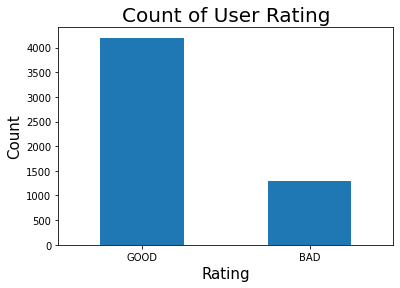

In [273]:
# plt.figure(figsize=(20,10))
final_df['new_rating'].value_counts().plot.bar(rot=0)

plt.title('Count of User Rating',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10);

It appears we have a class imbalance problem where the number of 5.0 reviews are much greater than the other reviews. Oversampling the minority classes will lead to overfitting due to a creation of large number of synthetic rows. To address this, I will take a set number of random samples from each class.

## Undersampling

In [274]:
def undersampling(dataframe, column, list_user_rating, samples):
    df = pd.DataFrame()
    for rating in list_user_rating:
        sample = dataframe[dataframe[column] == rating].sample(samples)
        df = df.append(sample)
    return df

In [275]:
undersampled_df =undersampling(final_df, 'new_rating', final_df['new_rating'].unique(), 1200)
undersampled_df.shape

(2400, 12)

In [276]:
undersampled_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,new_rating
1615,B07F454YF3,Leder Games Root: A Game of Woodland Might and...,56.99,4.8,456,R1KXGFQZYN1AWT,Poor quality of parts.,I had just open my copy of Root that just ar...,2.0,poor quality parts,open copy root arrive player mat felt soft squ...,BAD
10,B076HK9H7Z,Sorry! Game,0.00,4.7,7555,R3C3FCTLE3MO2L,Missing pieces,"Just opened the game to find a missing blue,...",1.0,missing pieces,open game find miss blue red green piece,BAD
1798,B083XX769B,Avalon Hill Scooby Doo in Betrayal at Mystery ...,27.26,4.7,353,RQWU7XDYS3B8T,Good entry level game for younger players.,"After 3 plays, I really wanted to enjoy this...",3.0,good entry level game younger players,play really want enjoy game haunt seem fall fl...,BAD
1879,B01ISKSRK8,"Hasbro Gaming Mouse Trap Game,Brown",19.99,4.5,2023,R2AYOKHI7ES9V9,Pieces don’t line up,Bought as a gift from Santa so I’m not able ...,1.0,pieces dont line,buy gift santa im able return without come sor...,BAD
2122,B00000DMFD,Hasbro Gaming Mouse Trap Board Game For Kids A...,22.92,4.5,2515,R2PP7QBEHILIPH,So poorly made,Had to separate all the plastic parts and on...,1.0,poorly made,separate plastic part one break process set ga...,BAD


In [277]:
undersampled_df['new_rating'].value_counts()

BAD     1200
GOOD    1200
Name: new_rating, dtype: int64

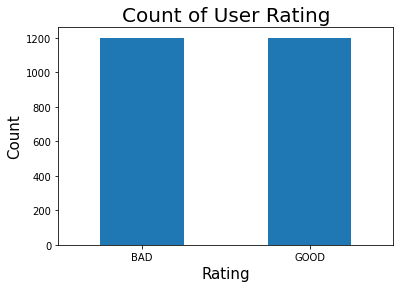

In [278]:
# plt.figure(figsize=(20,10))
undersampled_df['new_rating'].value_counts().plot.bar(rot=0)

plt.title('Count of User Rating',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10);

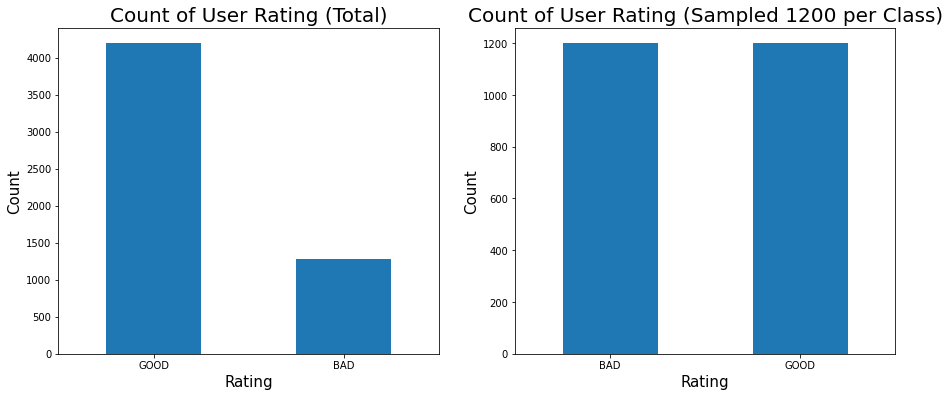

In [279]:
plt.subplot(1,2,1)
final_df['new_rating'].value_counts().plot.bar(rot=0, figsize=(15,6))
plt.title('Count of User Rating (Total)',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10)

plt.subplot(1,2,2)
undersampled_df['new_rating'].value_counts().plot.bar(rot=0, figsize=(15,6))
plt.title('Count of User Rating (Sampled 1200 per Class)',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel('Count',fontsize=15)
plt.yticks(fontsize=10)

plt.savefig('images/count_of_user_rating_undersampled.png');

# TF-IDF Vectorization

Stands for Term Frequency, Inverse Document Frequency and weighs each word in a document by how unique it is. The idea behind TF-IDF is that the words that occur less in all the documents and more in individual documents are weighted more.

In [280]:
# declare variables for reviews and rating
reviews = undersampled_df['cleaned_reviews'].values
rating = undersampled_df['new_rating'].values

In [281]:
# convert text into TF-IDF feature vectors

vectorizer = TfidfVectorizer(max_features=2500, # num of most frequent occuring words to create bag of words vector
                             min_df=7, # minimum words that occur in at least 7 documents
                             max_df=0.8, # words that occur in a maximum of 80% of documents
                             stop_words=stopwords.words('english'))

processed_features = vectorizer.fit_transform(reviews).toarray()

In [282]:
print(vectorizer)
print(processed_features)

TfidfVectorizer(max_df=0.8, max_features=2500, min_df=7,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.05884256 0.         ... 0.         0.         0.        ]]


# Train Test Split

In [283]:
X_train, X_test, y_train, y_test = train_test_split(processed_features,
                                                    rating, 
                                                    test_size=0.2, # 80% training/20% test
                                                    random_state=0)

# Logistic Regression

In [284]:
logreg_classifier = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear',random_state=0)
logreg_classifier.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=0,
                   solver='liblinear')

In [285]:
logreg_classifier.predict(X_train)[0:5]

array(['GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD'], dtype=object)

In [286]:
logreg_predictions = logreg_classifier.predict(X_test)
logreg_predictions

array(['GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD',
       'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD',
       'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD',
       'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD',
       'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD',
       'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'B

## Result

### Confusion Matrix

In [287]:
print(confusion_matrix(y_test, logreg_predictions))

[[183  65]
 [ 55 177]]


### Classification Report

In [288]:
print(classification_report(y_test, logreg_predictions))

              precision    recall  f1-score   support

         BAD       0.77      0.74      0.75       248
        GOOD       0.73      0.76      0.75       232

    accuracy                           0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.75      0.75      0.75       480



### Accuracy Score

In [289]:
print(accuracy_score(y_test, logreg_predictions))

0.75


In [290]:
accuracy_results = pd.DataFrame({'Model':['Logistic Regression'], 'Accuracy':[accuracy_score(y_test, logreg_predictions)]})
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.75


# Random Forest

## GridSearchCV

In [291]:
# # Perform a gridsearch for Random Forest
# # Obtain optimal values of model hyperparameters

# RF_classifier = RandomForestClassifier(random_state=0)

# params = {'max_depth': [10, 20, 30], # Maximum number of levels in tree
#          'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
#          'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
#          'n_estimators': [200, 500, 1000]} # The number of trees in the forest

# g_s_RF = GridSearchCV(RF_classifier,param_grid=params, n_jobs=-1) # create gridsearch with input params
# grid_result = g_s_RF.fit(X_train, y_train) # fit gridsearch with training data
# best_params = grid_result.best_params_ # output best params for given data
# best_params

In [292]:
RF_classifier = RandomForestClassifier(criterion='gini',
                                       max_depth=30,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       n_estimators=1000, 
                                       random_state=0)
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=1000, random_state=0)

In [293]:
RF_predictions = RF_classifier.predict(X_test)
RF_predictions

array(['GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD',
       'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD',
       'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD',
       'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD',
       'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD',
       'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD',
       'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD',
       'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD',
       'BAD', 'BAD', 'GOOD', 'BAD', 'GOO

## Results

### Confusion Matrix

In [294]:
print(confusion_matrix(y_test, RF_predictions))

[[189  59]
 [ 40 192]]


### Classification Report

In [295]:
print(classification_report(y_test, RF_predictions))

              precision    recall  f1-score   support

         BAD       0.83      0.76      0.79       248
        GOOD       0.76      0.83      0.80       232

    accuracy                           0.79       480
   macro avg       0.80      0.79      0.79       480
weighted avg       0.80      0.79      0.79       480



### Accuracy Score

In [296]:
print(accuracy_score(y_test, RF_predictions))

0.79375


In [297]:
accuracy_results = accuracy_results.append({'Model':'Random Forest', 'Accuracy':accuracy_score(y_test, RF_predictions)},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.75000
1,Random Forest,0.79375


### Plot Comparison between Actuals and Predicted

In [298]:
predictions_count = dict(Counter(RF_predictions))
predictions_count_df = pd.DataFrame.from_dict(predictions_count, orient ='index', columns =['Predictions'])

y_test_count = dict(Counter(y_test))
y_test_count_df = pd.DataFrame.from_dict(y_test_count, orient ='index', columns =['Actuals'])

random_forest_df = pd.concat([predictions_count_df, y_test_count_df], axis=1).fillna(0)

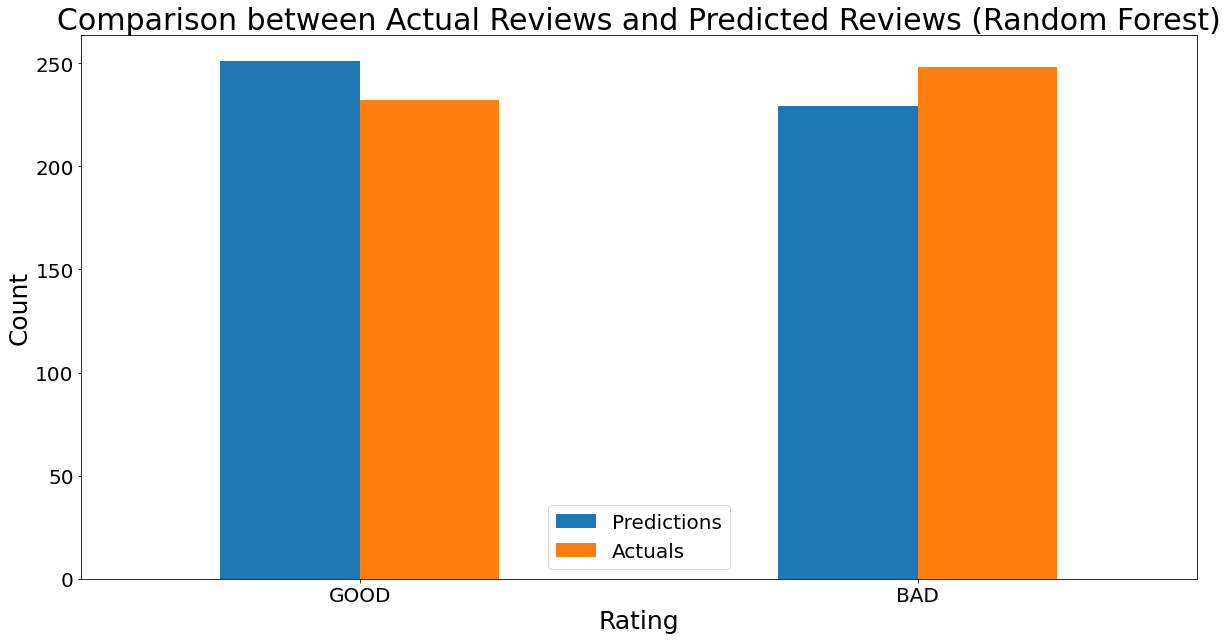

In [299]:
random_forest_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews (Random Forest)',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# K-Nearest Neighbors (KNN)

In [300]:
# # Perform a gridsearch for Random Forest
# # Obtain optimal values of model hyperparameters

# KNN_classifier = KNeighborsClassifier()

# params = {'n_neighbors': [5,15,25], # Number of neighbors
#              'weights': ['uniform','distance']} # Weight function used in prediction

# g_s_KNN = GridSearchCV(KNN_classifier,param_grid=params, n_jobs=-1) # create gridsearch with input params
# grid_result = g_s_KNN.fit(X_train, y_train) # fit gridsearch with training data
# best_params = grid_result.best_params_ # output best params for given data
# best_params

In [301]:
KNN_classifier = KNeighborsClassifier(n_neighbors=25,weights='uniform')
KNN_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [302]:
KNN_predictions = KNN_classifier.predict(X_test)
KNN_predictions

array(['GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD',
       'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD',
       'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD',
       'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD',
       

## Results

### Confusion Matrix

In [303]:
print(confusion_matrix(y_test, KNN_predictions))

[[157  91]
 [ 33 199]]


### Classification Report

In [304]:
print(classification_report(y_test, KNN_predictions))

              precision    recall  f1-score   support

         BAD       0.83      0.63      0.72       248
        GOOD       0.69      0.86      0.76       232

    accuracy                           0.74       480
   macro avg       0.76      0.75      0.74       480
weighted avg       0.76      0.74      0.74       480



### Accuracy Score

In [305]:
print(accuracy_score(y_test, KNN_predictions))

0.7416666666666667


In [306]:
accuracy_results = accuracy_results.append({'Model':'KNN', 'Accuracy':accuracy_score(y_test, KNN_predictions)},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.793750
2,KNN,0.741667


### Plot Comparison between Actuals and Predicted

In [307]:
predictions_count = dict(Counter(KNN_predictions))
predictions_count_df = pd.DataFrame.from_dict(predictions_count, orient ='index', columns =['Predictions'])

y_test_count = dict(Counter(y_test))
y_test_count_df = pd.DataFrame.from_dict(y_test_count, orient ='index', columns =['Actuals'])

KNN_df = pd.concat([predictions_count_df, y_test_count_df], axis=1).fillna(0)

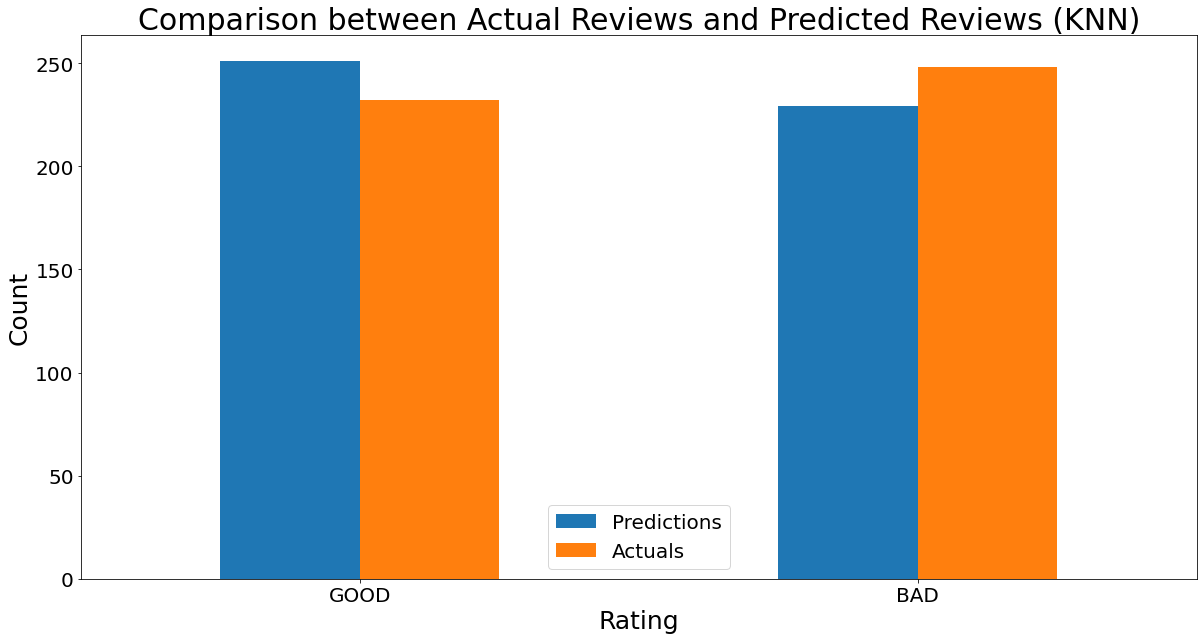

In [308]:
random_forest_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews (KNN)',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# SVM

In [309]:
# # Perform a gridsearch for Random Forest
# # Obtain optimal values of model hyperparameters

# SVM_classifier = SVC()

# params = [{'C': np.logspace(-3, 2, 6), 
#            'gamma': np.logspace(-3, 2, 6)}]

# g_s_SVM = GridSearchCV(SVM_classifier,param_grid=params, n_jobs=-1) # create gridsearch with input params
# grid_result = g_s_SVM.fit(X_train, y_train) # fit gridsearch with training data
# best_params = grid_result.best_params_ # output best params for given data
# best_params

In [310]:
SVM_classifier = SVC(C=100.0, gamma=0.01,random_state=0)
SVM_classifier.fit(X_train, y_train)

SVC(C=100.0, gamma=0.01, random_state=0)

In [311]:
SVM_predictions = SVM_classifier.predict(X_test)
SVM_predictions

array(['GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD',
       'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD', 'BAD', 'BAD',
       'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD',
       'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'BAD', 'GOOD',
       'BAD', 'GOOD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'GOOD', 'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'GOOD', 'GOOD', 'BAD', 'BAD', 'BAD', 'GOOD', 'BAD', 'BAD',
       'BAD', 'BAD', 'BAD', 'BAD', 'GOOD', 'GOOD', 'BAD', 'GOOD', 'GOOD',
       'GOOD', 'BAD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'GOOD', 'BAD',
       'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 'BAD', 

## Results

### Confusion Matrix

In [312]:
print(confusion_matrix(y_test, SVM_predictions))

[[195  53]
 [ 50 182]]


### Classification Report

In [313]:
print(classification_report(y_test, SVM_predictions))

              precision    recall  f1-score   support

         BAD       0.80      0.79      0.79       248
        GOOD       0.77      0.78      0.78       232

    accuracy                           0.79       480
   macro avg       0.79      0.79      0.79       480
weighted avg       0.79      0.79      0.79       480



### Accuracy Score

In [314]:
print(accuracy_score(y_test, SVM_predictions))

0.7854166666666667


In [315]:
accuracy_results = accuracy_results.append({'Model':'SVM', 'Accuracy':accuracy_score(y_test, SVM_predictions)},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.793750
2,KNN,0.741667
3,SVM,0.785417


### Plot Comparison between Actuals and Predicted

In [316]:
predictions_count = dict(Counter(SVM_predictions))
predictions_count_df = pd.DataFrame.from_dict(predictions_count, orient ='index', columns =['Predictions'])

y_test_count = dict(Counter(y_test))
y_test_count_df = pd.DataFrame.from_dict(y_test_count, orient ='index', columns =['Actuals'])

KNN_df = pd.concat([predictions_count_df, y_test_count_df], axis=1).fillna(0)

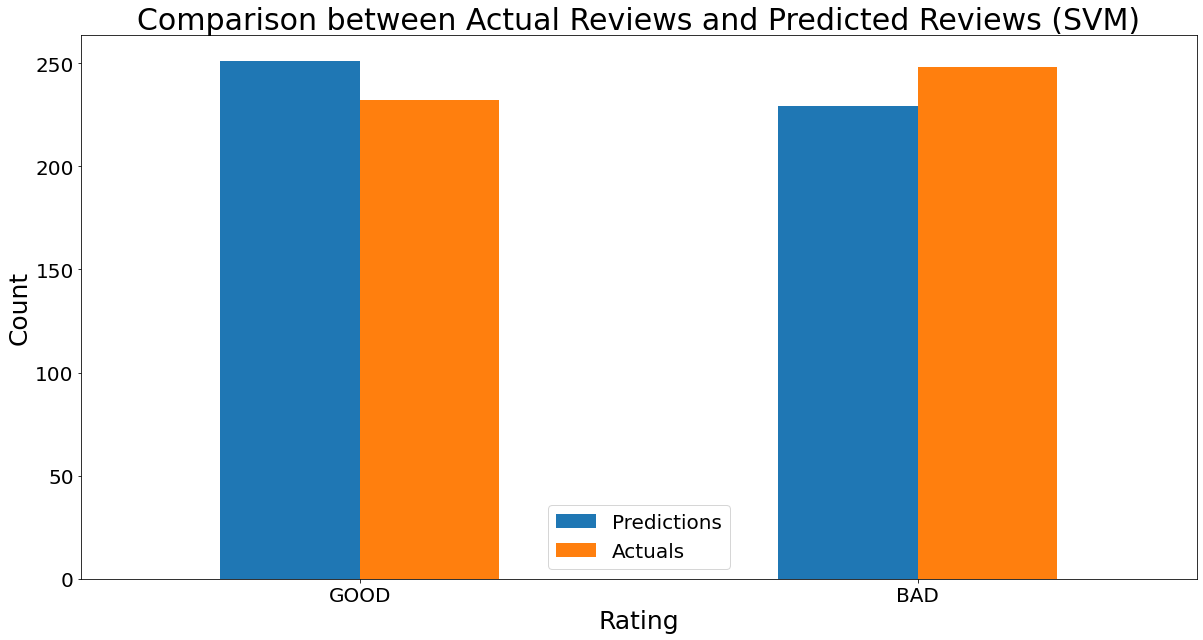

In [317]:
random_forest_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews (SVM)',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# Sentiment Analyzer using NLTK Module Vader

* works well with social media type text
* doesn't require any training data and is constructed using human-curated sentiment lexicon

In [318]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [319]:
def sentiment_analyzer_scores(sentence):
    # polarity_scores: ranging from -1 (most neg) to 1 (most pos)
    score = analyser.polarity_scores(sentence)
    return score # {neg: Negative, neu: Neutral, pos: Positive, compound: Aggregated Score}

In [320]:
def compound_score(text):
    comp=sentiment_analyzer_scores(text)
    return comp['compound'] # returns the compound score from the dictionary

In [321]:
# applying on the reviews column to get the score
final_df['sentiment_score'] = final_df['review_description'].apply(lambda x:compound_score(x))

In [322]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,new_rating,sentiment_score
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero star could youre original sorr...,BAD,0.8548
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawn per team instead trad...,BAD,-0.4873
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,buy replace old sorry game fall apart wish rea...,BAD,0.2885
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warn sorry grow three token per player rule di...,BAD,0.8726
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawn card instead dice...,GOOD,0.9565


In [323]:
def sentiment_category(score):
    if score >= 0.2:
        return 'GOOD'
    else:
        return 'BAD'

In [324]:
final_df['sentiment_score_rating'] = final_df['sentiment_score'].apply(lambda x: sentiment_category(x))

In [325]:
final_df.head()

,asin_id,name,price,avg_rating,no_of_ratings,review_id,review_title,review_description,user_rating,cleaned_title,cleaned_reviews,new_rating,sentiment_score,sentiment_score_rating
0,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1OSPWS88F2CUZ,DO NOT BUY!!!,I would give this zero stars if I could! If ...,1.0,buy,would give zero star could youre original sorr...,BAD,0.8548,GOOD
1,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1DCFJ8VYSN17B,Is this the millennial version?,This is not the original sorry game. It only...,1.0,millennial version,original sorry game pawn per team instead trad...,BAD,-0.4873,BAD
2,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R1V07N4GXA7RSL,Wimp and Crybaby Edition,We bought this to replace our old Sorry game...,1.0,wimp crybaby edition,buy replace old sorry game fall apart wish rea...,BAD,0.2885,GOOD
3,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,R2Z262NZDEU2EY,NOT the original/regular Sorry!,Be warned that this is not the sorry you gre...,2.0,originalregular sorry,warn sorry grow three token per player rule di...,BAD,0.8726,GOOD
4,B076HK9H7Z,Sorry! Game,0.0,4.7,7555,RG3XIFV1PUX9Y,"Not the classic by a long shot, but okay.","Definitely not the classic game, with only 3...",4.0,classic long shot okay,definitely classic game pawn card instead dice...,GOOD,0.9565,GOOD


## Results

### Confusion Matrix

In [326]:
cnf_matrix = confusion_matrix(final_df['new_rating'],final_df['sentiment_score_rating'])
cnf_matrix

array([[ 546,  742],
       [ 232, 3967]])

### Classification Report

In [327]:
print(classification_report(final_df['new_rating'],final_df['sentiment_score_rating']))

              precision    recall  f1-score   support

         BAD       0.70      0.42      0.53      1288
        GOOD       0.84      0.94      0.89      4199

    accuracy                           0.82      5487
   macro avg       0.77      0.68      0.71      5487
weighted avg       0.81      0.82      0.81      5487



### Accuracy Score

In [328]:
from sklearn.metrics import accuracy_score
vader_accuracy_score = accuracy_score(final_df['new_rating'],final_df['sentiment_score_rating'])
vader_accuracy_score

0.822489520685256

In [329]:
accuracy_results = accuracy_results.append({'Model':'Vader', 'Accuracy':vader_accuracy_score},ignore_index=True)
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.793750
2,KNN,0.741667
3,SVM,0.785417
4,Vader,0.822490


### Plot Comparison between Actuals and Predicted

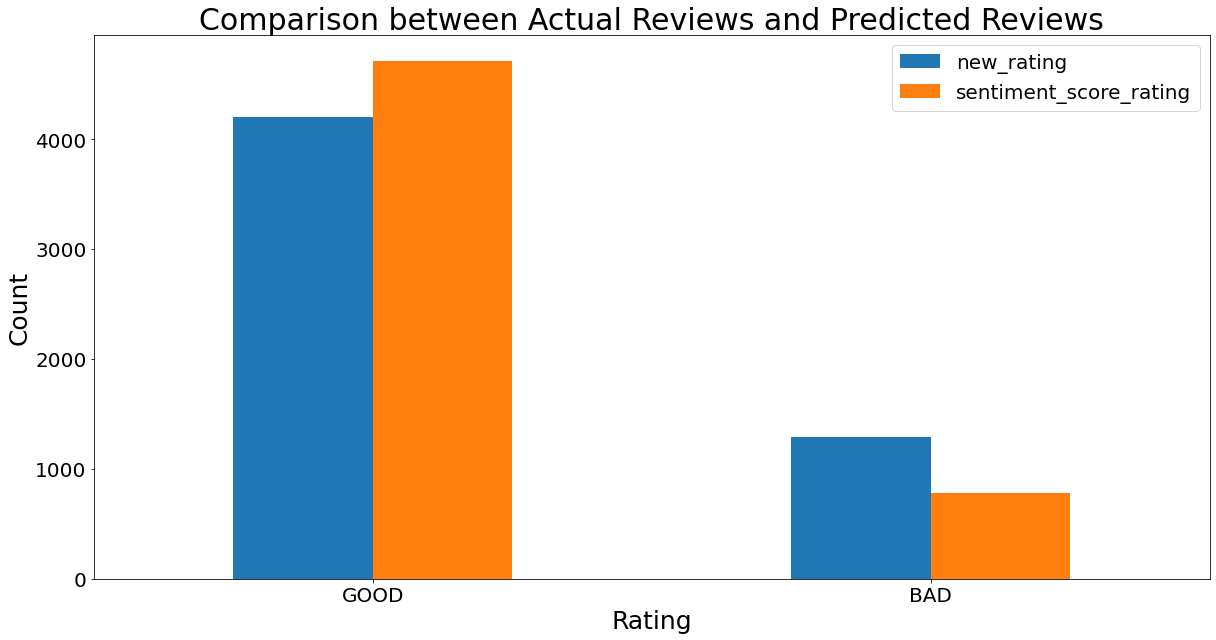

In [330]:
review_rating_counts = final_df['new_rating'].value_counts()
sentiment_score_rating_counts = final_df['sentiment_score_rating'].value_counts()

review_df = pd.concat([review_rating_counts, sentiment_score_rating_counts], axis=1)

review_df.plot.bar(rot=0, figsize=(20,10))

plt.title('Comparison between Actual Reviews and Predicted Reviews',fontsize=30)

plt.xlabel('Rating',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Count',fontsize=25)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

# Predictive Accuracy Results

In [331]:
accuracy_results

,Model,Accuracy
0,Logistic Regression,0.750000
1,Random Forest,0.793750
2,KNN,0.741667
3,SVM,0.785417
4,Vader,0.822490


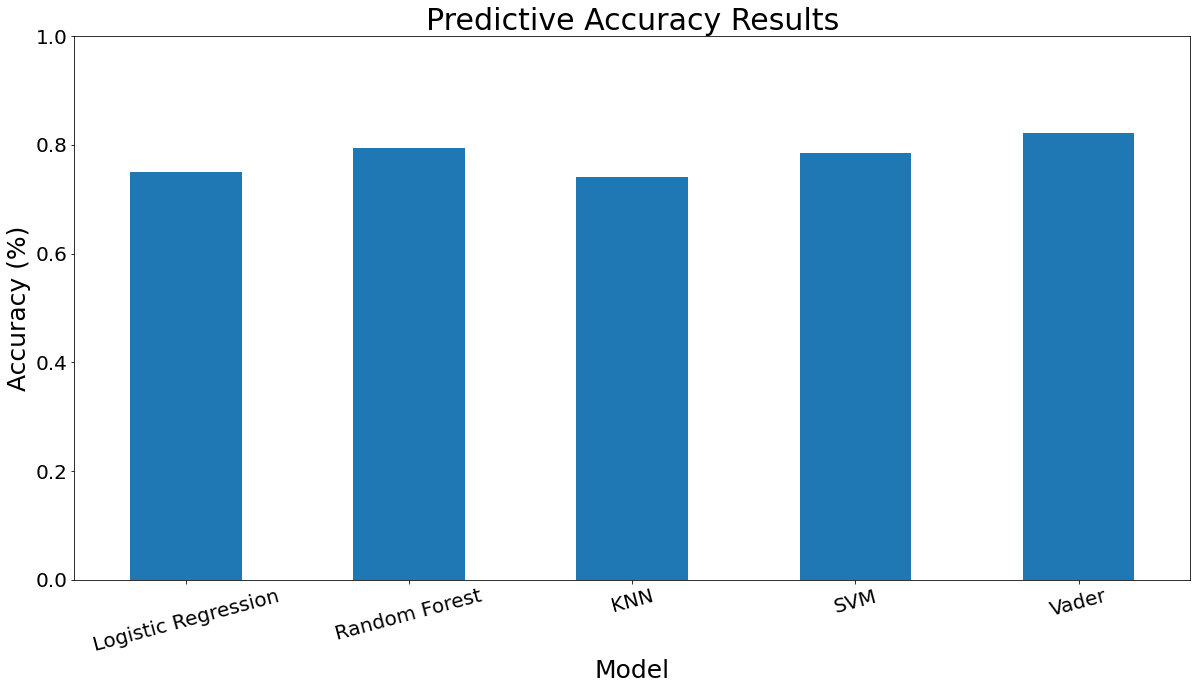

In [332]:
accuracy_results.plot.bar('Model','Accuracy', rot=15, figsize=(20,10))

plt.title('Predictive Accuracy Results',fontsize=30)
plt.xlabel('Model',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Accuracy (%)',fontsize=25)
plt.yticks(fontsize=20)
plt.ylim(0, 1.0)

plt.legend().remove();